Source: Udacity Github

<h1> Finding Lane Lines on the Road</h1>


In [0]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [0]:
!mkdir test_images

import os

os.chdir('test_images')

In [52]:
# first load image to read
# When you the code, it provides option to load into 

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving solidWhiteCurve.jpg to solidWhiteCurve.jpg
Saving solidWhiteRight.jpg to solidWhiteRight.jpg
Saving solidYellowCurve.jpg to solidYellowCurve.jpg
Saving solidYellowCurve2.jpg to solidYellowCurve2.jpg
Saving solidYellowLeft.jpg to solidYellowLeft.jpg
Saving whiteCarLaneSwitch.jpg to whiteCarLaneSwitch.jpg
User uploaded file "solidWhiteCurve.jpg" with length 50222 bytes
User uploaded file "solidWhiteRight.jpg" with length 70682 bytes
User uploaded file "solidYellowCurve.jpg" with length 58719 bytes
User uploaded file "solidYellowCurve2.jpg" with length 66163 bytes
User uploaded file "solidYellowLeft.jpg" with length 67939 bytes
User uploaded file "whiteCarLaneSwitch.jpg" with length 60676 bytes


This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


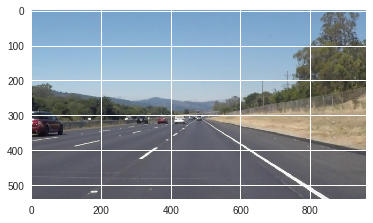

In [53]:
#reading in an image
image = mpimg.imread('solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [0]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [55]:
import os
os.listdir("./")

['solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg']

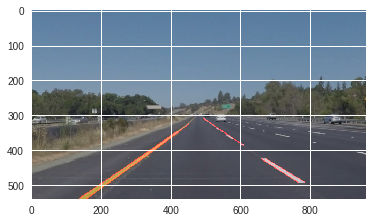

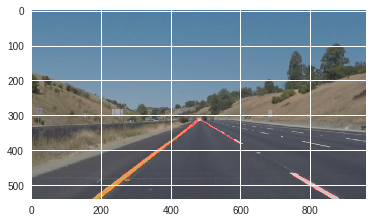

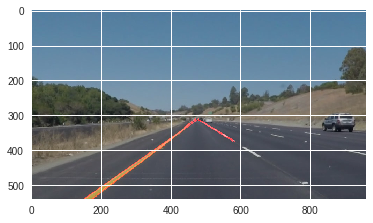

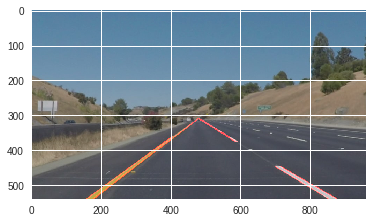

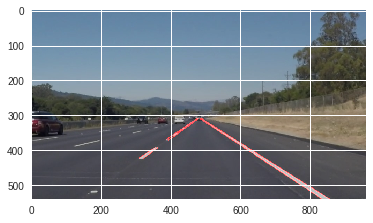

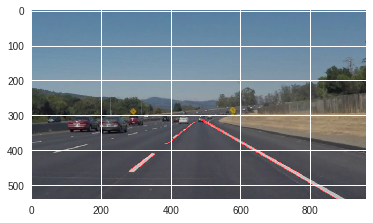

In [57]:

#some constants
KERNEL_SIZE = 3
LOW_THRESHOLD = 75 # threshold for canny edge detector
HIGH_THRESHOLD = 150 # threshold for canny edge detector

BOTTOM_SHIFT = 75 # use for creating area of interest region
TOP_SHIFT = 40 # use for creating area of interest region

RHO = 2 # distance resolution in pixels of the Hough grid
THETA = np.pi/180 # angular resolution in radians of the Hough grid
MIN_VOTES = 100    # minimum number of votes (intersections in Hough grid cell)
MIN_LINE_LEN = 25 #minimum number of pixels making up a line
MAX_LINE_GAP = 25   # maximum gap in pixels between connectable line segments 

# building the image processing pipeline
def build_pipeline(image):
    grayscale_image = grayscale(image)
    
    smooth_image = gaussian_blur(grayscale_image, KERNEL_SIZE)
    
    edges = canny(smooth_image, LOW_THRESHOLD, HIGH_THRESHOLD)
    
    image_height = image.shape[0]
    image_width = image.shape[1]
    
    vertices = np.array([[(BOTTOM_SHIFT, image_height),
                        (image_width / 2 - TOP_SHIFT, image_height / 2 + TOP_SHIFT), 
                        (image_width /2 + TOP_SHIFT, image_height / 2 + TOP_SHIFT),
                        (image_width - BOTTOM_SHIFT, image_height)]], dtype=np.int32)
    
    regions = region_of_interest(edges, vertices)
    
    hough_image = hough_lines(regions, RHO, THETA, MIN_VOTES, MIN_LINE_LEN, MAX_LINE_GAP)
    return weighted_img(hough_image, image)

for test_image in os.listdir("./"):
    img = mpimg.imread(test_image)
    plt.imshow(build_pipeline(img))
    plt.show()

In [59]:
!pip install moviepy

    100% |████████████████████████████████| 378kB 13.4MB/s 
    100% |████████████████████████████████| 3.3MB 3.4MB/s 
  Running setup.py bdist_wheel for moviepy ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/ad/92/4d/a6c6307d4c2219d002646bd4a5987e31fd5697f6ea7778b2c0
  Running setup.py bdist_wheel for imageio ... - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built moviepy imageio


In [60]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1474560/45929032 bytes (3.2%)4620288/45929032 bytes (10.1%)7938048/45929032 bytes (17.3%)11165696/45929032 bytes (24.3%)14123008/45929032 bytes (30.7%)17571840/45929032 bytes (38.3%)20742144/45929032 bytes (45.2%)23879680/45929032 bytes (52.0%)27017216/45929032 bytes (58.8%)30277632/45929032 bytes (65.9%)33579008/45929032 bytes (73.1%)36831232/45929032 bytes (80.2%)

In [0]:
def process_image(image):
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    global height, width
    height = image.shape[0]
    width = image.shape[1]
    interest = np.array([[0, height], [width*3/8, height*5/8], [width*5/8, height*5/8], [width, height]], np.int32)

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (20, 80, 80), (25, 255, 255))
    white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    gray = cv2.bitwise_or(yellow, white)
    edges = canny(gray, 64, 192)
    roi = region_of_interest(edges, [interest])
    out = hough_lines(roi, 1, np.pi/180, 32, 1, 200)
    result = weighted_img(image, out, 0.9, 0.9)
    return result

In [62]:
a = Smooth()
image = cv2.imread('test_images/solidYellowCurve.jpg')
# image = cv2.imread('test_images/solidWhiteCurve.jpg')
# image = cv2.imread('test_images/challenge.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height = image.shape[0]
width = image.shape[1]
interest = np.array([[0, height], [width*3/8, height*5/8], [width*5/8, height*5/8], [width, height]], np.int32)

hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
yellow = cv2.inRange(hsv, (20, 80, 80), (25, 255, 255))
white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
gray = cv2.bitwise_or(yellow, white)
edges = canny(gray, 64, 192)
roi = region_of_interest(edges, [interest])
roi2 = region_of_interest(gray, [interest])
lines = hough_lines(roi2, 1, np.pi/180, 32, 1, 200)
result = weighted_img(image, lines, 0.9, 0.9)

def showimg(subplace, title, _img):
    plt.subplot(*subplace)
    plt.title(title)
    if len(_img.shape) == 3:
        plt.imshow(_img)
    else:
        plt.imshow(_img, cmap='gray')

plt.figure(figsize=[16, 9])
for i, imgname in enumerate(['image', 'yellow', 'white', 'gray', 'edges', 'roi', 'roi2', 'lines', 'result']):
    showimg((3, 3, i+1), imgname, eval(imgname))

NameError: ignored

In [0]:
a = Smooth(windowsize=5)
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [0]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [0]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(yellow_output))